# **1. Import libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import random
import tda_tuning

# TDA
import networkx as nx
import kmapper as km
from sklearn.cluster import DBSCAN
from tmap.tda.utils import optimize_dbscan_eps
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from umap.umap_ import UMAP
from kmapper.plotlyviz import plotlyviz

# Graph distance metrics
import netcomp as nc
from netrd.distance import NetSimile

In [2]:
# Set seed for reproducibility
seed_value = 27
random.seed(seed_value)

# **2. Load data**

In [3]:
fMRI_data = pd.read_csv('data.csv')

# Remove class labels
x_fMRI = fMRI_data.drop('study_group', axis=1)

# Dummy variables of class labels
y_fMRI = pd.get_dummies(fMRI_data['study_group'])
y_fMRI = y_fMRI.astype('int')


# **3. TDA**

In [4]:
# Mapper
mapper = km.KeplerMapper(verbose=1)

KeplerMapper()


# **4. Grid search**

In [5]:
# Define Cover parameters range of values (resolution, gain)

res_range = [0.35, 0.40, 0.45, 0.50, 0.55, 0.60, 0.65, 0.70, 0.75]
gain_range = [10,15,20,25,30,35,40,45,50]

n_res = len(res_range)
n_gain = len(gain_range)

n_iteration = len(res_range)*len(gain_range)
print('Number of iterations: ', n_iteration)

Number of iterations:  81


In [6]:
# Bootstrapping
n_bootstraps = 5
bootstrap_samples = tda_tuning.get_bootstrap_sample(x_fMRI, n_bootstraps)

## **4.1. PCA**

In [7]:
matrix_lambda_pca = np.zeros((n_res, n_gain))
matrix_netsimile_pca = np.zeros((n_res, n_gain))
matrix_efficiency_pca = np.zeros((n_res, n_gain))

pca = PCA(n_components=2, random_state=42)

for i in range(len(res_range)):

    res_current = res_range[i]

    for j in range(len(gain_range)):
        print("ITERATION RES n." + str(i+1)+" out of " + str(len(res_range)) + " TOT")
        print("ITERATION GAIN n." + str(j+1)+" out of " + str(len(gain_range)) + " TOT")
        
        gain_current = gain_range[j]

        # Graph creation
        graph_list = []
        for k in range(len(bootstrap_samples)):
            lens_pca = mapper.fit_transform(pca.fit_transform(bootstrap_samples[k], y=None), projection=[0,1])
            graph = mapper.map(
                lens_pca, X=bootstrap_samples[k],
                cover=km.Cover(perc_overlap=res_current, n_cubes=gain_current),
                clusterer=DBSCAN(eps=optimize_dbscan_eps(bootstrap_samples[k], threshold=95), min_samples=2)
            )
            # Convert to networkx graph
            graph_nx = km.adapter.to_nx(graph)
            graph_list.append(graph_nx)

        # Graph distance
        lambda_dist = tda_tuning.graph_distance_metric(graph_list, metric='lambda')
        netsimile_dist = tda_tuning.graph_distance_metric(graph_list, metric='netsimile')
            
        # Topological property computation (global efficiency)
        efficiency_list = []
        for l in range(len(graph_list)):
            efficiency_list.append(nx.global_efficiency(graph_list[l]))

        avg_efficiency = sum(efficiency_list)/len(efficiency_list)

        # Save results
        matrix_lambda_pca[i,j] = lambda_dist
        matrix_netsimile_pca[i,j] = netsimile_dist
        matrix_efficiency_pca[i,j] = avg_efficiency

ITERATION RES n.1 out of 9 TOT
ITERATION GAIN n.1 out of 9 TOT
..Composing projection pipeline of length 1:
	Projections: [0, 1]
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (411, 2)

..Projecting data using: [0, 1]

..Scaling with: MinMaxScaler()

Mapping on data shaped (411, 12720) using lens shaped (411, 2)

Creating 100 hypercubes.

Created 99 edges and 36 nodes in 0:00:00.377670.
..Composing projection pipeline of length 1:
	Projections: [0, 1]
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (411, 2)

..Projecting data using: [0, 1]

..Scaling with: MinMaxScaler()

Mapping on data shaped (411, 12720) using lens shaped (411, 2)

Creating 100 hypercubes.

Created 79 edges and 33 nodes in 0:00:00.123858.
..Composing projection pipeline of length 1:
	Projections: [0, 1]
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (411, 2)

..Projecting data using: [0, 1]

..Scaling with: MinMaxScaler()


## **4.2. UMAP**

In [8]:
matrix_lambda_umap = np.zeros((n_res, n_gain))
matrix_netsimile_umap = np.zeros((n_res, n_gain))
matrix_efficiency_umap = np.zeros((n_res, n_gain))

pca = PCA(n_components=2, random_state=42)

for i in range(len(res_range)):

    res_current = res_range[i]

    for j in range(len(gain_range)):
        print("ITERATION RES n." + str(i+1)+" out of " + str(len(res_range)) + " TOT")
        print("ITERATION GAIN n." + str(j+1)+" out of " + str(len(gain_range)) + " TOT")
        
        gain_current = gain_range[j]

        # Graph creation
        graph_list = []
        for k in range(len(bootstrap_samples)):
            umap = UMAP(n_components=2, init=pca.fit_transform(bootstrap_samples[k]))
            lens_umap = mapper.fit_transform(umap.fit_transform(bootstrap_samples[k], y=None), projection=[0,1])
            graph = mapper.map(
                lens_umap, X=bootstrap_samples[k],
                cover=km.Cover(perc_overlap=res_current, n_cubes=gain_current),
                clusterer=DBSCAN(eps=optimize_dbscan_eps(bootstrap_samples[k], threshold=95), min_samples=2)
            )
            # Convert to networkx graph
            graph_nx = km.adapter.to_nx(graph)
            graph_list.append(graph_nx)

        # Graph distance
        lambda_dist = tda_tuning.graph_distance_metric(graph_list, metric='lambda')
        netsimile_dist = tda_tuning.graph_distance_metric(graph_list, metric='netsimile')
            
        # Topological property computation (global efficiency)
        efficiency_list = []
        for l in range(len(graph_list)):
            efficiency_list.append(nx.global_efficiency(graph_list[l]))

        avg_efficiency = sum(efficiency_list)/len(efficiency_list)

        # Save results
        matrix_lambda_umap[i,j] = lambda_dist
        matrix_netsimile_umap[i,j] = netsimile_dist
        matrix_efficiency_umap[i,j] = avg_efficiency

ITERATION RES n.1 out of 9 TOT
ITERATION GAIN n.1 out of 9 TOT
..Composing projection pipeline of length 1:
	Projections: [0, 1]
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (411, 2)

..Projecting data using: [0, 1]

..Scaling with: MinMaxScaler()

Mapping on data shaped (411, 12720) using lens shaped (411, 2)

Creating 100 hypercubes.

Created 260 edges and 88 nodes in 0:00:00.415871.
..Composing projection pipeline of length 1:
	Projections: [0, 1]
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (411, 2)

..Projecting data using: [0, 1]

..Scaling with: MinMaxScaler()

Mapping on data shaped (411, 12720) using lens shaped (411, 2)

Creating 100 hypercubes.

Created 253 edges and 87 nodes in 0:00:00.139674.
..Composing projection pipeline of length 1:
	Projections: [0, 1]
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (411, 2)

..Projecting data using: [0, 1]

..Scaling with: MinMaxScaler(

## **4.3. t-SNE**

In [9]:
matrix_lambda_tsne = np.zeros((n_res, n_gain))
matrix_netsimile_tsne = np.zeros((n_res, n_gain))
matrix_efficiency_tsne = np.zeros((n_res, n_gain))

pca = PCA(n_components=2, random_state=42)

for i in range(len(res_range)):

    res_current = res_range[i]

    for j in range(len(gain_range)):
        print("ITERATION RES n." + str(i+1)+" out of " + str(len(res_range)) + " TOT")
        print("ITERATION GAIN n." + str(j+1)+" out of " + str(len(gain_range)) + " TOT")
        
        gain_current = gain_range[j]

        # Graph creation
        graph_list = []
        for k in range(len(bootstrap_samples)):
            tsne = TSNE(n_components=2, init=pca.fit_transform(bootstrap_samples[k]))
            lens_tsne = mapper.fit_transform(tsne.fit_transform(bootstrap_samples[k], y=None), projection=[0,1])
            graph = mapper.map(
                lens_tsne, X=bootstrap_samples[k],
                cover=km.Cover(perc_overlap=res_current, n_cubes=gain_current),
                clusterer=DBSCAN(eps=optimize_dbscan_eps(bootstrap_samples[k], threshold=95), min_samples=2)
            )
            # Convert to networkx graph
            graph_nx = km.adapter.to_nx(graph)
            graph_list.append(graph_nx)

        # Graph distance
        lambda_dist = tda_tuning.graph_distance_metric(graph_list, metric='lambda')
        netsimile_dist = tda_tuning.graph_distance_metric(graph_list, metric='netsimile')
            
        # Topological property computation (global efficiency)
        efficiency_list = []
        for l in range(len(graph_list)):
            efficiency_list.append(nx.global_efficiency(graph_list[l]))

        avg_efficiency = sum(efficiency_list)/len(efficiency_list)

        # Save results
        matrix_lambda_tsne[i,j] = lambda_dist
        matrix_netsimile_tsne[i,j] = netsimile_dist
        matrix_efficiency_tsne[i,j] = avg_efficiency

ITERATION RES n.1 out of 9 TOT
ITERATION GAIN n.1 out of 9 TOT
..Composing projection pipeline of length 1:
	Projections: [0, 1]
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (411, 2)

..Projecting data using: [0, 1]

..Scaling with: MinMaxScaler()

Mapping on data shaped (411, 12720) using lens shaped (411, 2)

Creating 100 hypercubes.

Created 223 edges and 82 nodes in 0:00:00.208740.
..Composing projection pipeline of length 1:
	Projections: [0, 1]
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (411, 2)

..Projecting data using: [0, 1]

..Scaling with: MinMaxScaler()

Mapping on data shaped (411, 12720) using lens shaped (411, 2)

Creating 100 hypercubes.

Created 214 edges and 74 nodes in 0:00:00.213360.
..Composing projection pipeline of length 1:
	Projections: [0, 1]
	Distance matrices: False
	Scalers: MinMaxScaler()
..Projecting on data shaped (411, 2)

..Projecting data using: [0, 1]

..Scaling with: MinMaxScaler(

# **5. Results analysis**

In [10]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = mpl.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

In [11]:
# Resolution and Gain ranges
res = ['0.35', '0.40', '0.45', '0.50', '0.55', '0.60', '0.65', '0.70', '0.75']
gain = ['10', '15', '20', '25', '30', '35', '40', '45', '50']

## **5.1. PCA results**

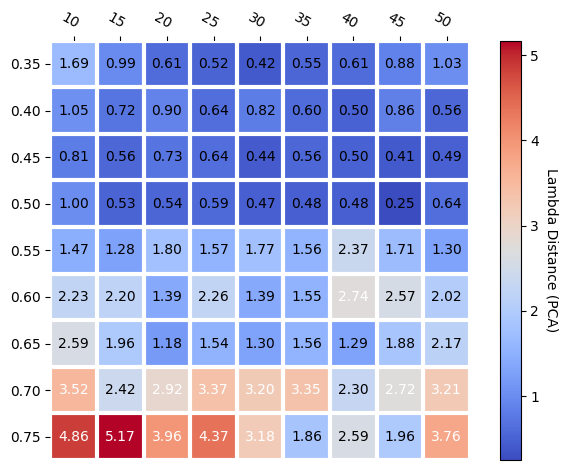

<Figure size 640x480 with 0 Axes>

In [22]:
# Heatmap visualization
fig, ax = plt.subplots()

im, cbar = heatmap(np.around(matrix_lambda_pca, decimals=2, out=None), res, gain, ax=ax,
                   cmap="coolwarm", cbarlabel="Lambda Distance (PCA)")
texts = annotate_heatmap(im, valfmt="{x:.2f}")

fig.tight_layout()
plt.show()
plt.savefig('results/heatmap_lambda_pca.png', dpi=300)

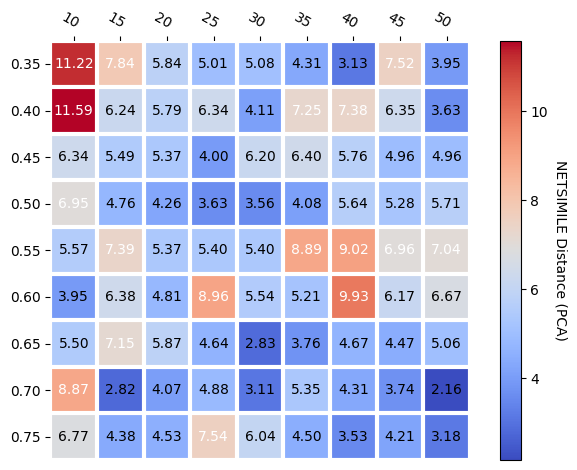

<Figure size 640x480 with 0 Axes>

In [23]:
# Heatmap visualization
fig, ax = plt.subplots()

im, cbar = heatmap(np.around(matrix_netsimile_pca, decimals=2, out=None), res, gain, ax=ax,
                   cmap="coolwarm", cbarlabel="NETSIMILE Distance (PCA)")
texts = annotate_heatmap(im, valfmt="{x:.2f}")

fig.tight_layout()
plt.show()
plt.savefig('results/heatmap_netsimile_pca.png', dpi=300)

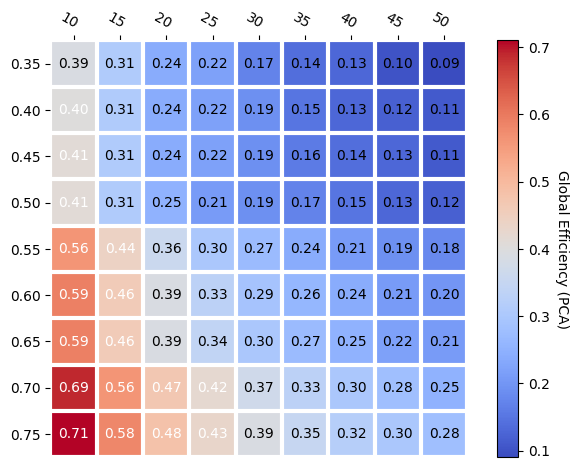

<Figure size 640x480 with 0 Axes>

In [24]:
# Heatmap visualization
fig, ax = plt.subplots()

im, cbar = heatmap(np.around(matrix_efficiency_pca, decimals=2, out=None), res, gain, ax=ax,
                   cmap="coolwarm", cbarlabel="Global Efficiency (PCA)")
texts = annotate_heatmap(im, valfmt="{x:.2f}")

fig.tight_layout()
plt.show()
plt.savefig('results/heatmap_efficiency_pca.png', dpi=300)

## **5.2. UMAP results**

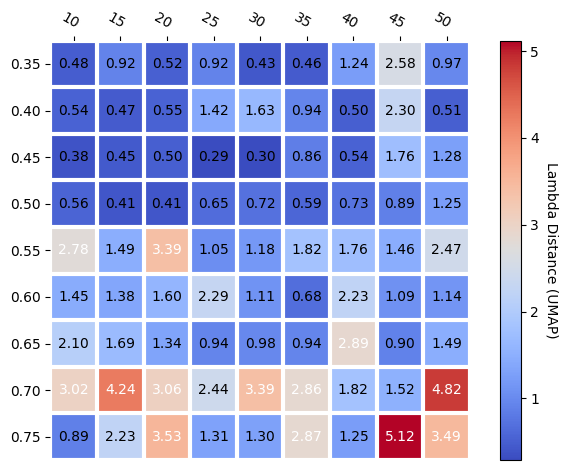

<Figure size 640x480 with 0 Axes>

In [25]:
# Heatmap visualization
fig, ax = plt.subplots()

im, cbar = heatmap(np.around(matrix_lambda_umap, decimals=2, out=None), res, gain, ax=ax,
                   cmap="coolwarm", cbarlabel="Lambda Distance (UMAP)")
texts = annotate_heatmap(im, valfmt="{x:.2f}")

fig.tight_layout()
plt.show()
plt.savefig('results/heatmap_lambda_umap.png', dpi=300)

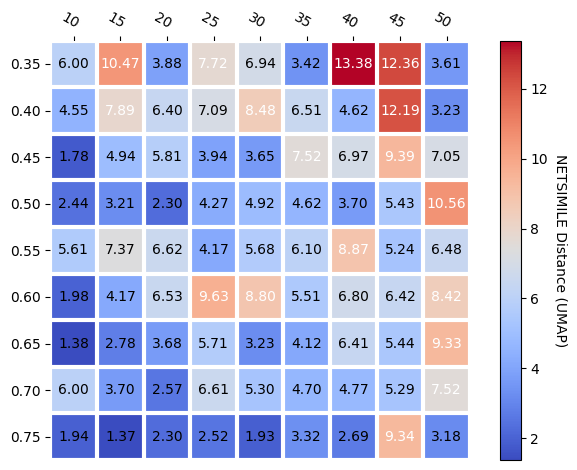

<Figure size 640x480 with 0 Axes>

In [26]:
# Heatmap visualization
fig, ax = plt.subplots()

im, cbar = heatmap(np.around(matrix_netsimile_umap, decimals=2, out=None), res, gain, ax=ax,
                   cmap="coolwarm", cbarlabel="NETSIMILE Distance (UMAP)")
texts = annotate_heatmap(im, valfmt="{x:.2f}")

fig.tight_layout()
plt.show()
plt.savefig('results/heatmap_netsimile_umap.png', dpi=300)

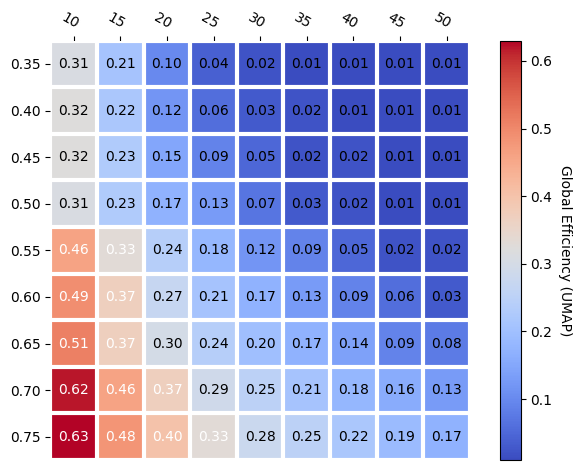

<Figure size 640x480 with 0 Axes>

In [27]:
# Heatmap visualization
fig, ax = plt.subplots()

im, cbar = heatmap(np.around(matrix_efficiency_umap, decimals=2, out=None), res, gain, ax=ax,
                   cmap="coolwarm", cbarlabel="Global Efficiency (UMAP)")
texts = annotate_heatmap(im, valfmt="{x:.2f}")

fig.tight_layout()
plt.show()
plt.savefig('results/heatmap_efficiency_umap.png', dpi=300)

## **5.3. t-SNE results**

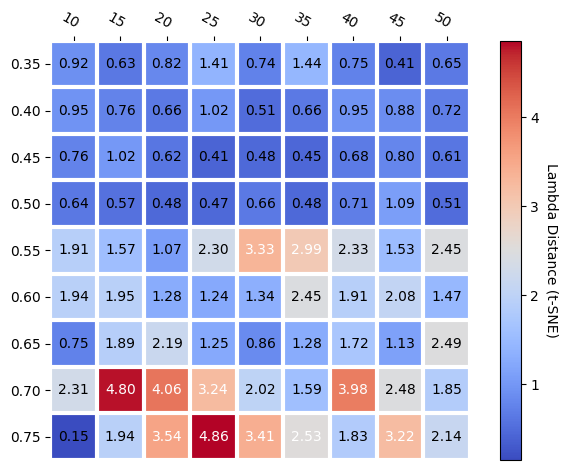

<Figure size 640x480 with 0 Axes>

In [28]:
# Heatmap visualization
fig, ax = plt.subplots()

im, cbar = heatmap(np.around(matrix_lambda_tsne, decimals=2, out=None), res, gain, ax=ax,
                   cmap="coolwarm", cbarlabel="Lambda Distance (t-SNE)")
texts = annotate_heatmap(im, valfmt="{x:.2f}")

fig.tight_layout()
plt.show()
plt.savefig('results/heatmap_lambda_tsne.png', dpi=300)

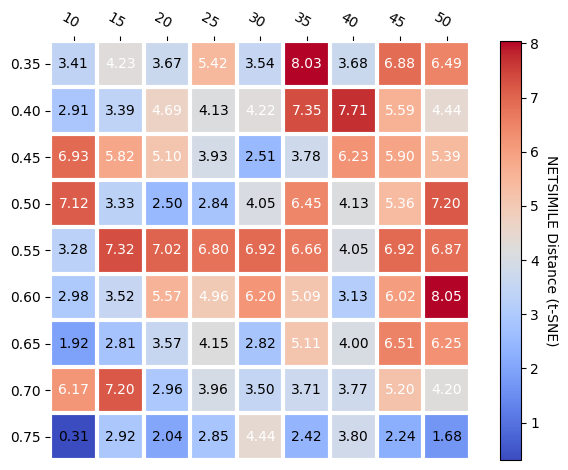

<Figure size 640x480 with 0 Axes>

In [29]:
# Heatmap visualization
fig, ax = plt.subplots()

im, cbar = heatmap(np.around(matrix_netsimile_tsne, decimals=2, out=None), res, gain, ax=ax,
                   cmap="coolwarm", cbarlabel="NETSIMILE Distance (t-SNE)")
texts = annotate_heatmap(im, valfmt="{x:.2f}")

fig.tight_layout()
plt.show()
plt.savefig('results/heatmap_netsimile_tsne.png', dpi=300)

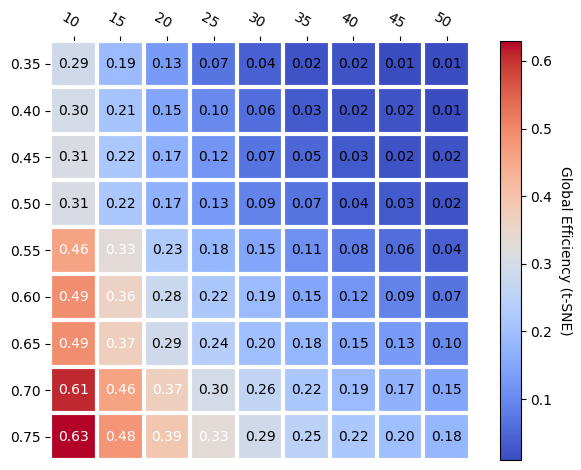

<Figure size 640x480 with 0 Axes>

In [30]:
# Heatmap visualization
fig, ax = plt.subplots()

im, cbar = heatmap(np.around(matrix_efficiency_tsne, decimals=2, out=None), res, gain, ax=ax,
                   cmap="coolwarm", cbarlabel="Global Efficiency (t-SNE)")
texts = annotate_heatmap(im, valfmt="{x:.2f}")

fig.tight_layout()
plt.show()
plt.savefig('results/heatmap_efficiency_tsne.png', dpi=300)